In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import snpytools as snpy
def q(sql):
    return snpy.df_from_presto(sql, user_name = 'devon.bancroft')

### Breaking Push open rate exploration

#### Questions:
1. What is the relationship between category and open rate?
2. What is the relationship between title length and open rate?
3. How does including "Trump" in the title affect open rate? "Impeachment"?
4. What is the trend of open rates overtime? By category?

Segmentations: platform (iOS vs Android)

### Getting number of opens by url and platform

In [2]:
df = q('''
SELECT a.dt, a.title, a.url, b.cat, c.platform, c.opens
FROM
(SELECT * FROM (SELECT date_format(from_unixtime(sent_flg), '%Y-%m-%d') AS dt,
          title,
          url
   FROM rds.smartnews.breaking_push
   WHERE edition = 'en_US'
     AND target_user = 1)
   WHERE dt BETWEEN '2019-07-02' AND '2019-10-29') a
INNER JOIN
(SELECT url, min(cat) as cat
from articles
CROSS JOIN UNNEST(category) as t(cat)
WHERE lang = 'EN'
AND dt > '2019-06-01'
GROUP BY 1) b on a.url=b.url
LEFT JOIN
(SELECT platform, url, count(*) as opens
FROM actions
WHERE action = 'receivePush'
AND dt BETWEEN '2019-07-02' AND '2019-10-29'
AND edition = 'en_US'
GROUP BY 1, 2) c on a.url=c.url
''')

SELECT a.dt,
       a.title,
       a.url,
       b.cat,
       c.platform,
       c.opens
FROM
  (SELECT *
   FROM
     (SELECT date_format(from_unixtime(sent_flg), '%Y-%m-%d') AS dt,
             title,
             url
      FROM rds.smartnews.breaking_push
      WHERE edition = 'en_US'
        AND target_user = 1)
   WHERE dt BETWEEN '2019-07-02' AND '2019-10-29') a
INNER JOIN
  (SELECT url,
          min(cat) AS cat
   FROM articles
   CROSS JOIN UNNEST(category) AS t(cat)
   WHERE lang = 'EN'
     AND dt > '2019-06-01'
   GROUP BY 1) b ON a.url=b.url
LEFT JOIN
  (SELECT platform,
          url,
          count(*) AS opens
   FROM actions
   WHERE action = 'receivePush'
     AND dt BETWEEN '2019-07-02' AND '2019-10-29'
     AND edition = 'en_US'
   GROUP BY 1,
            2) c ON a.url=c.url
Length of dataframe is 790
Top 5 rows of the dataframe:
           dt                                              title  \
0  2019-07-03        Federal judge blocks Ohio anti-abortion law   


In [3]:
df.head()

,dt,title,url,cat,platform,opens
0,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,android,76236
1,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,ios,12286
2,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,android,136187
3,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,ios,29194
4,2019-07-10,UK Ambassador Who Called Trump ‘Inept’ And ‘Dy...,https://www.huffpost.com/entry/uk-ambassador-r...,EN_US_POLITICS,android,82727


In [4]:
df.shape

(790, 6)

In [5]:
df.describe()

,opens
count,790.000000
mean,57755.725316
std,48276.882901
min,4.000000
25%,14101.000000
50%,40874.500000
75%,96552.500000
max,208753.000000


In [6]:
df.sort_values(by = 'opens').head(10)

,dt,title,url,cat,platform,opens
603,2019-08-24,"Lightning strikes at PGA Tour Championship, si...",https://golfweek.com/2019/08/24/lightning-stri...,EN_US_SPORTS,ios,4
249,2019-10-23,Trump says U.S. will lift Turkey sanctions as ...,https://www.bloomberg.com/news/articles/2019-1...,EN_US_POLITICS,ios,6
415,2019-10-24,Boris Johnson seeks early general election to ...,https://www.bloomberg.com/news/articles/2019-1...,EN_US_WORLD,ios,11
329,2019-10-23,Google says it has achieved ‘quantum supremacy...,https://www.theverge.com/2019/10/23/20928294/g...,EN_US_TECHNOLOGY,ios,14
673,2019-10-24,House committee subpoenas agency for Trump DC ...,https://www.cnn.com/2019/10/24/politics/transp...,EN_US_POLITICS,ios,19
670,2019-10-23,Police find body in dumpster believed to be mi...,https://abcnews.go.com/US/police-find-body-dum...,EN_US_NATIONAL,ios,21
414,2019-10-24,Boris Johnson seeks early general election to ...,https://www.bloomberg.com/news/articles/2019-1...,EN_US_WORLD,android,202
248,2019-10-23,Trump says U.S. will lift Turkey sanctions as ...,https://www.bloomberg.com/news/articles/2019-1...,EN_US_POLITICS,android,205
672,2019-10-24,House committee subpoenas agency for Trump DC ...,https://www.cnn.com/2019/10/24/politics/transp...,EN_US_POLITICS,android,221
602,2019-08-24,"Lightning strikes at PGA Tour Championship, si...",https://golfweek.com/2019/08/24/lightning-stri...,EN_US_SPORTS,android,437


10/23 and 10/24 was a push outage

In [7]:
df.dtypes

dt          object
title       object
url         object
cat         object
platform    object
opens        int64
dtype: object

Casting dt column as datetime data type

In [8]:
df.dt = pd.to_datetime(df.dt)

In [9]:
df.dtypes

dt          datetime64[ns]
title               object
url                 object
cat                 object
platform            object
opens                int64
dtype: object

In [10]:
df = df[(df.dt != '2019-10-23') & (df.dt != '2019-10-24')].copy()

Checking for more outliers

In [11]:
df.sort_values(by='opens')

,dt,title,url,cat,platform,opens
603,2019-08-24,"Lightning strikes at PGA Tour Championship, si...",https://golfweek.com/2019/08/24/lightning-stri...,EN_US_SPORTS,ios,4
602,2019-08-24,"Lightning strikes at PGA Tour Championship, si...",https://golfweek.com/2019/08/24/lightning-stri...,EN_US_SPORTS,android,437
413,2019-10-17,Boris Johnson has finally agreed a Brexit deal...,https://www.businessinsider.com/boris-johnson-...,EN_US_WORLD,ios,5322
281,2019-10-22,Boris Johnson wants Brexit by October 31. Parl...,https://www.vox.com/2019/10/22/20926907/brexit...,EN_US_POLITICS,ios,5514
616,2019-10-16,GM and UAW reach tentative deal that could end...,https://apnews.com/be0a22ea7772427dbf545450119...,EN_US_BUSINESS,ios,5828
...,...,...,...,...,...,...
452,2019-07-04,Earthquake with preliminary 6.4 magnitude rock...,https://abcnews.go.com/US/earthquake-prelimina...,EN_US_NATIONAL,android,193192
46,2019-09-03,‘American Idol’ Contestant Haley Smith Dies in...,https://www.tmz.com/2019/09/03/american-idol-c...,EN_US_ENTERTAINMENT,android,198934
510,2019-09-05,Country Singer Kylie Rae Harris Dies at Age 30,https://www.billboard.com/articles/columns/cou...,EN_US_ENTERTAINMENT,android,201672
221,2019-08-07,USA TODAY headquarters evacuated after police ...,https://www.usatoday.com/story/news/politics/2...,EN_US_NATIONAL,android,208753


In [12]:
df = df[df.opens > 1000].copy()

In [13]:
df.describe()

,opens
count,774.000000
mean,58772.328165
std,48097.792585
min,5322.000000
25%,14419.750000
50%,46358.000000
75%,96622.000000
max,208753.000000


### Getting sent count for each article

In [14]:
df1 = q(
    '''
    SELECT
          link_url as url,
          platform,
          COUNT(DISTINCT a.user_id) AS sent_count
   FROM smartnews.push_send_urls_detailed a
   INNER JOIN
     (SELECT DISTINCT dt,
                      user_id
      FROM daily_user_fq_segment
      WHERE dt BETWEEN '2019-07-01' AND '2019-11-01'
        AND edition = 'en_US') b ON a.dt = b.dt
   AND a.user_id = b.user_id
   WHERE a.dt BETWEEN '2019-07-01' AND '2019-11-01'
     AND a.edition = 'en_US'
     AND BREAKING_PUSH_CONDITION_ID IS NOT NULL
   GROUP BY 1, 2
    '''
)

SELECT link_url AS url,
       platform,
       COUNT(DISTINCT a.user_id) AS sent_count
FROM smartnews.push_send_urls_detailed a
INNER JOIN
  (SELECT DISTINCT dt,
                   user_id
   FROM daily_user_fq_segment
   WHERE dt BETWEEN '2019-07-01' AND '2019-11-01'
     AND edition = 'en_US') b ON a.dt = b.dt
AND a.user_id = b.user_id
WHERE a.dt BETWEEN '2019-07-01' AND '2019-11-01'
  AND a.edition = 'en_US'
  AND BREAKING_PUSH_CONDITION_ID IS NOT NULL
GROUP BY 1,
         2
Length of dataframe is 870
Top 5 rows of the dataframe:
                                                 url platform  sent_count
0  https://abcnews.go.com/US/legendary-journalist...  android     2782988
1  https://abcnews.go.com/US/active-shooter-incid...  android     2541944
2  https://www.nbcnews.com/politics/donald-trump/...      ios      622450
3  https://www.reuters.com/article/us-usa-fed-idU...      ios           6
4  https://www.cnn.com/2019/08/28/politics/johnny...  android           1


In [15]:
df1.head()

,url,platform,sent_count
0,https://abcnews.go.com/US/legendary-journalist...,android,2782988
1,https://abcnews.go.com/US/active-shooter-incid...,android,2541944
2,https://www.nbcnews.com/politics/donald-trump/...,ios,622450
3,https://www.reuters.com/article/us-usa-fed-idU...,ios,6
4,https://www.cnn.com/2019/08/28/politics/johnny...,android,1


In [16]:
df1.shape

(870, 3)

In [17]:
df.shape

(774, 6)

In [18]:
df[~df.url.isin(df1.url)]

,dt,title,url,cat,platform,opens


In [19]:
df = df.merge(df1, on=['url', 'platform'], how='left')

In [20]:
df.head()

,dt,title,url,cat,platform,opens,sent_count
0,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,android,76236,2707846
1,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,ios,12286,593894
2,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,android,136187,2692045
3,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,ios,29194,567169
4,2019-07-10,UK Ambassador Who Called Trump ‘Inept’ And ‘Dy...,https://www.huffpost.com/entry/uk-ambassador-r...,EN_US_POLITICS,android,82727,2676041


Adding open rate calc

In [21]:
df['open_rate'] = round((df.opens / df.sent_count) *100, 3)

In [22]:
df.head()

,dt,title,url,cat,platform,opens,sent_count,open_rate
0,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,android,76236,2707846,2.815
1,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,ios,12286,593894,2.069
2,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,android,136187,2692045,5.059
3,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,ios,29194,567169,5.147
4,2019-07-10,UK Ambassador Who Called Trump ‘Inept’ And ‘Dy...,https://www.huffpost.com/entry/uk-ambassador-r...,EN_US_POLITICS,android,82727,2676041,3.091


### Exploring Data

#### Distribution of open rates

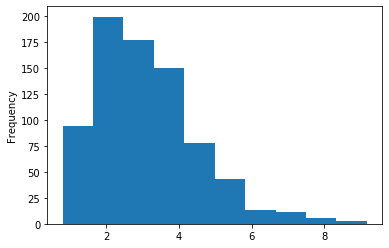

In [144]:
df.open_rate.plot(kind='hist')

#### Open rates by category

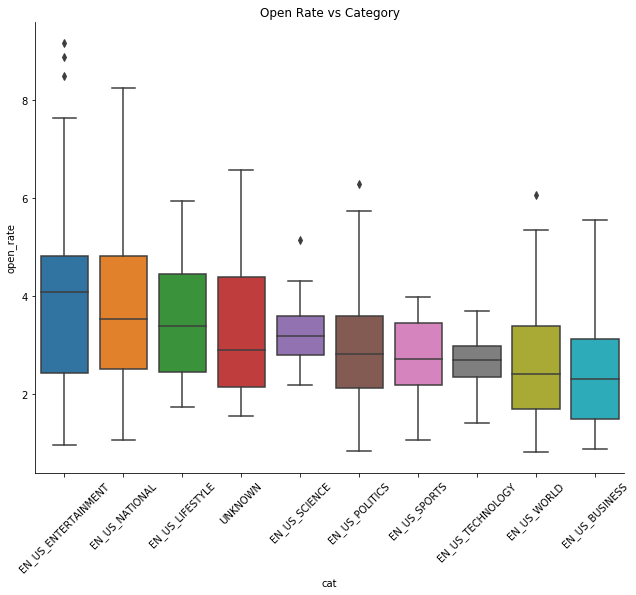

In [314]:
my_order = df.groupby(by=["cat"])["open_rate"].mean().sort_values(ascending=False).index
sns.catplot(x='cat', y='open_rate', kind='box', data=df, height=7, aspect=1.3, order=my_order);
plt.xticks(rotation=45);
plt.title("Open Rate vs Category");

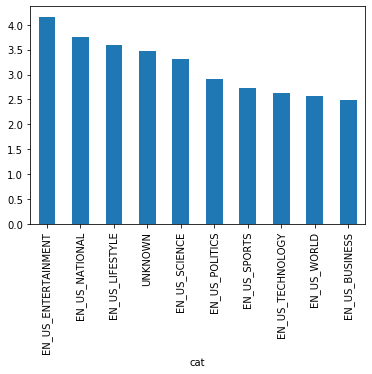

In [332]:
df.groupby('cat').open_rate.mean().reindex(my_order.to_list()).plot(kind='bar');

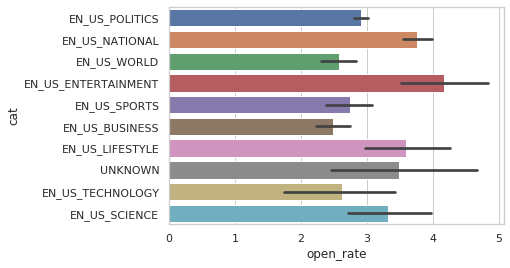

In [340]:
sns.set(style="whitegrid")
ax = sns.barplot(y="cat", x="open_rate", data=df)

Number of BPs by category

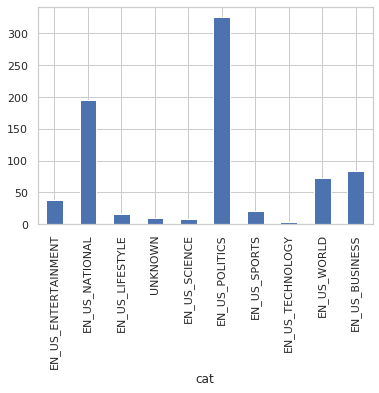

In [341]:
df.groupby('cat').url.count().reindex(my_order.to_list()).plot(kind='bar');

#### Findings:

*Entertainment, Lifestyle and National BP have the highest average open rates.*

*National and Entertainment have the highest ceiling*

*World and Biz have the lowest*

#### What is the trend of open rates over time?

In [291]:
totalOpenRate = round((df.groupby(['dt']).agg({
    'opens':'sum', 'sent_count':'sum'}).opens / df.groupby(['dt']).agg({
    'opens':'sum', 'sent_count':'sum'}).sent_count) * 100, 2)

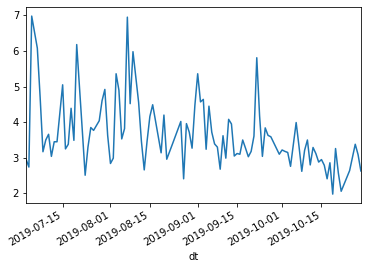

In [292]:
totalOpenRate.plot()

#### How about by week?

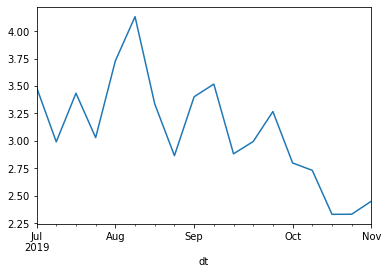

In [54]:
df.set_index('dt').resample('w').mean().open_rate.plot();

#### How about by category?

In [115]:
df.cat.unique()

array(['EN_US_POLITICS', 'EN_US_NATIONAL', 'EN_US_WORLD',
       'EN_US_ENTERTAINMENT', 'EN_US_SPORTS', 'EN_US_BUSINESS',
       'EN_US_LIFESTYLE', 'UNKNOWN', 'EN_US_TECHNOLOGY', 'EN_US_SCIENCE'],
      dtype=object)

In [120]:
biz = df[df.cat == 'EN_US_BUSINESS'].set_index('dt').resample('w').mean().open_rate.to_frame()
pol = df[df.cat == 'EN_US_POLITICS'].set_index('dt').resample('w').mean().open_rate.to_frame()
US = df[df.cat == 'EN_US_NATIONAL'].set_index('dt').resample('w').mean().open_rate.to_frame()
World = df[df.cat == 'EN_US_WORLD'].set_index('dt').resample('w').mean().open_rate.to_frame()
Ent = df[df.cat == 'EN_US_ENTERTAINMENT'].set_index('dt').resample('w').mean().open_rate.to_frame()
Sports = df[df.cat == 'EN_US_SPORTS'].set_index('dt').resample('w').mean().open_rate.to_frame()
Tech = df[df.cat == 'EN_US_TECHNOLOGY'].set_index('dt').resample('w').mean().open_rate.to_frame()
Science = df[df.cat == 'EN_US_SCIENCE'].set_index('dt').resample('w').mean().open_rate.to_frame()
Lifestyle = df[df.cat == 'EN_US_LIFESTYLE'].set_index('dt').resample('w').mean().open_rate.to_frame()

In [136]:
df[df.cat == 'EN_US_LIFESTYLE'].set_index('dt').resample('w').mean().open_rate.to_frame()

,open_rate
dt,
2019-07-28,3.04925
2019-08-04,NaN
2019-08-11,2.83950
2019-08-18,NaN
2019-08-25,NaN
2019-09-01,NaN
2019-09-08,3.99550
2019-09-15,3.38900
2019-09-22,4.22800


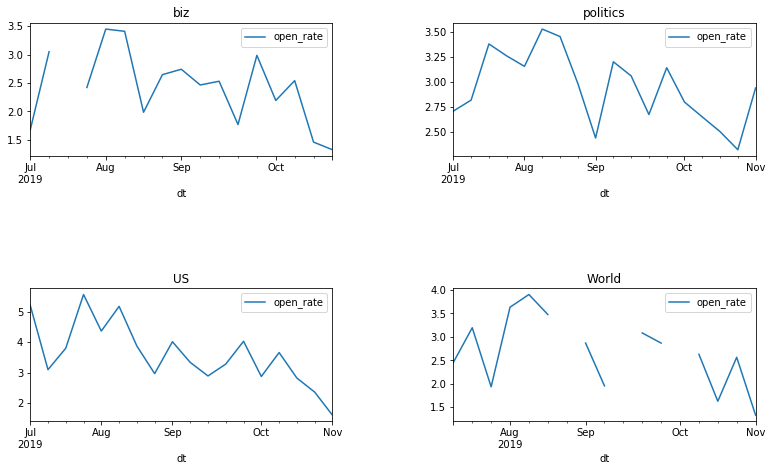

In [160]:
fix, ax = plt.subplots(2, 2, figsize=(13,7))
biz.plot(ax=ax[0,0], title = 'biz')
pol.plot(ax=ax[0,1], title = 'politics')
US.plot(ax=ax[1,0], title = 'US')
World.plot(ax=ax[1,1], title = 'World');

plt.subplots_adjust(top = 0.8, bottom=0.01, hspace=1.0, wspace=0.4)

#### Findings:<br>
*Open rate has been declining since Oct 1st*<br>
*Decline about the same for the major categories of push*

#### What is the relationship between number of BPs per day and open rate?

In [177]:
df.head()

,dt,title,url,cat,platform,opens,sent_count,open_rate
0,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,android,76236,2707846,2.815
1,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,ios,12286,593894,2.069
2,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,android,136187,2692045,5.059
3,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,ios,29194,567169,5.147
4,2019-07-10,UK Ambassador Who Called Trump ‘Inept’ And ‘Dy...,https://www.huffpost.com/entry/uk-ambassador-r...,EN_US_POLITICS,android,82727,2676041,3.091


In [186]:
open_rate_agg = round((df.groupby('dt').agg({'opens':'sum', 'sent_count':'sum'}).opens / df.groupby('dt').agg({
    'opens':'sum', 'sent_count':'sum'}).sent_count) * 100.0, 2).to_frame().rename({
    0:'open_rate'}, axis=1)

In [187]:
open_rate_agg

,open_rate
dt,
2019-07-02,2.96
2019-07-03,2.74
2019-07-04,6.98
2019-07-06,6.08
2019-07-07,4.70
...,...
2019-10-22,2.06
2019-10-25,2.64
2019-10-27,3.38


In [180]:
df2 = df.groupby('dt').url.nunique().to_frame().rename({'url':'BP_count'}, axis=1)

In [191]:
df2 = df2.merge(open_rate_agg, on='dt', how='left')

In [192]:
df2.head()

,BP_count,open_rate
dt,,
2019-07-02,2,2.96
2019-07-03,9,2.74
2019-07-04,1,6.98
2019-07-06,2,6.08
2019-07-07,2,4.70


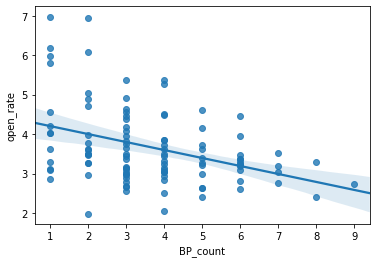

In [197]:
sns.regplot(x="BP_count", y="open_rate", data=df2);

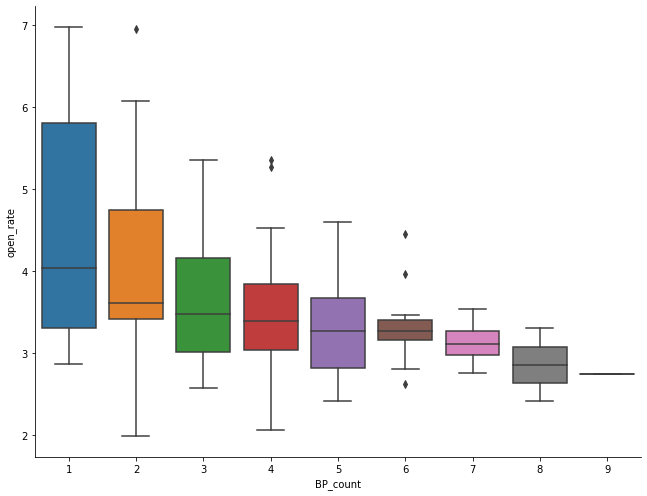

In [204]:
sns.catplot(x='BP_count', y='open_rate', kind='box', data=df2, height=7, aspect=1.3);

In [199]:
df2.corr()

,BP_count,open_rate
BP_count,1.00000,-0.38164
open_rate,-0.38164,1.00000


#### Findings:
*Negative relationship - as number of BPs goes up, open rate goes down*|

#### Have been sending more BPs (would this explain decreasing open rates?)

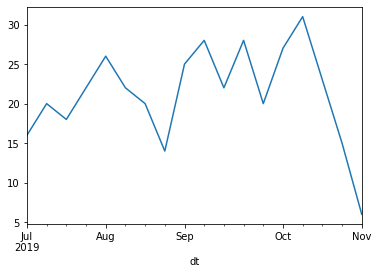

In [203]:
df.set_index('dt').resample('w').url.nunique().plot()

#### Finding:
*But number of BPs per week has not gone up dramatically*

#### What is the relationship between length of title and open rate by platform?

In [205]:
df.head()

,dt,title,url,cat,platform,opens,sent_count,open_rate
0,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,android,76236,2707846,2.815
1,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,ios,12286,593894,2.069
2,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,android,136187,2692045,5.059
3,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,ios,29194,567169,5.147
4,2019-07-10,UK Ambassador Who Called Trump ‘Inept’ And ‘Dy...,https://www.huffpost.com/entry/uk-ambassador-r...,EN_US_POLITICS,android,82727,2676041,3.091


In [209]:
df['title_length'] = df.apply(lambda x: len(x['title']), axis=1)

In [210]:
df.head()

,dt,title,url,cat,platform,opens,sent_count,open_rate,title_length
0,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,android,76236,2707846,2.815,43
1,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,ios,12286,593894,2.069,43
2,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,android,136187,2692045,5.059,83
3,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,ios,29194,567169,5.147,83
4,2019-07-10,UK Ambassador Who Called Trump ‘Inept’ And ‘Dy...,https://www.huffpost.com/entry/uk-ambassador-r...,EN_US_POLITICS,android,82727,2676041,3.091,66


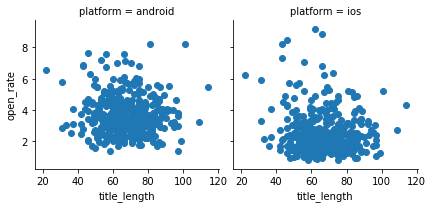

In [214]:
g = sns.FacetGrid(df, col="platform")
g.map(plt.scatter, "title_length", "open_rate")

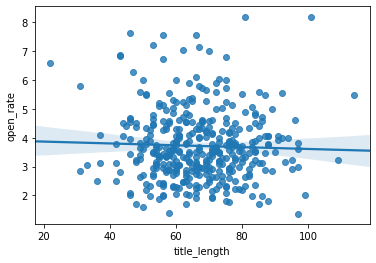

In [218]:
sns.regplot(x="title_length", y="open_rate", data=df[df.platform=='android']);

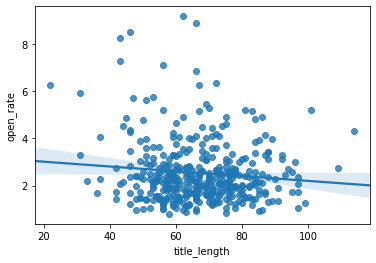

In [219]:
sns.regplot(x="title_length", y="open_rate", data=df[df.platform=='ios']);

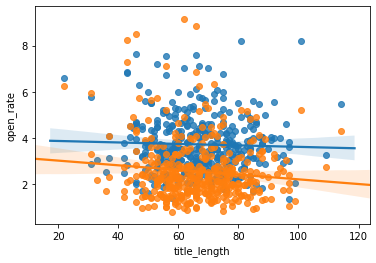

In [220]:
sns.regplot(x="title_length", y="open_rate", data=df[df.platform=='android']);
sns.regplot(x="title_length", y="open_rate", data=df[df.platform=='ios']);

In [222]:
df.groupby('platform').corr()

opens  sent_count  open_rate  title_length
platform                                                            
android  opens         1.000000   -0.141813   0.976993      0.007374
         sent_count   -0.141813    1.000000  -0.340348      0.198402
         open_rate     0.976993   -0.340348   1.000000     -0.035958
         title_length  0.007374    0.198402  -0.035958      1.000000
ios      opens         1.000000   -0.037727   0.996899     -0.099886
         sent_count   -0.037727    1.000000  -0.107181      0.103424
         open_rate     0.996899   -0.107181   1.000000     -0.105771
         title_length -0.099886    0.103424  -0.105771      1.000000

#### Finding:
*Only very slight negative relationship for iOS. Nothing for Android*

#### Does having the word "Trump" in the title correlate with open_rate?

In [223]:
df.head()

,dt,title,url,cat,platform,opens,sent_count,open_rate,title_length
0,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,android,76236,2707846,2.815,43
1,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,ios,12286,593894,2.069,43
2,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,android,136187,2692045,5.059,83
3,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,ios,29194,567169,5.147,83
4,2019-07-10,UK Ambassador Who Called Trump ‘Inept’ And ‘Dy...,https://www.huffpost.com/entry/uk-ambassador-r...,EN_US_POLITICS,android,82727,2676041,3.091,66


In [244]:
df['Trump?'] = df.url.isin(df[df.title.str.contains('Trump')].url)

In [245]:
df.head(2)

,dt,title,url,cat,platform,opens,sent_count,open_rate,title_length,Trump?
0,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,android,76236,2707846,2.815,43,False
1,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,ios,12286,593894,2.069,43,False


In [249]:
df['Trump?'] = df['Trump?'].map({True:1, False:0})

In [250]:
df.head()

,dt,title,url,cat,platform,opens,sent_count,open_rate,title_length,Trump?
0,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,android,76236,2707846,2.815,43,0
1,2019-07-03,Federal judge blocks Ohio anti-abortion law,https://www.reuters.com/article/us-usa-abortio...,EN_US_POLITICS,ios,12286,593894,2.069,43,0
2,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,android,136187,2692045,5.059,83,0
3,2019-07-06,Even more powerful quake shakes Southern Calif...,https://www.nbcnews.com/news/us-news/earthquak...,EN_US_NATIONAL,ios,29194,567169,5.147,83,0
4,2019-07-10,UK Ambassador Who Called Trump ‘Inept’ And ‘Dy...,https://www.huffpost.com/entry/uk-ambassador-r...,EN_US_POLITICS,android,82727,2676041,3.091,66,1


In [259]:
open_rate_agg2 = round((df.groupby(['dt', 'url', 'Trump?']).agg({'opens':'sum', 'sent_count':'sum'}).opens / df.groupby('dt').agg({
    'opens':'sum', 'sent_count':'sum'}).sent_count) * 100.0, 2).to_frame().rename({0:'open_rate'}, axis=1)

In [270]:
open_rate_agg2.reset_index(inplace=True)

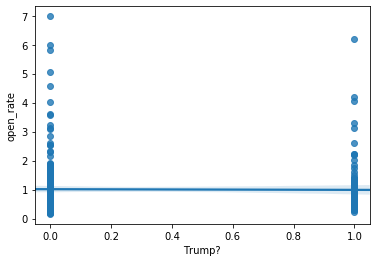

In [271]:
sns.regplot(x="Trump?", y="open_rate", data=open_rate_agg2);

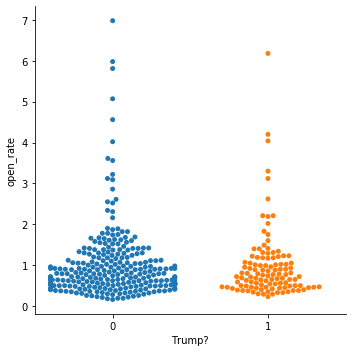

In [274]:
sns.catplot(x='Trump?',y='open_rate', kind='swarm', data=open_rate_agg2);

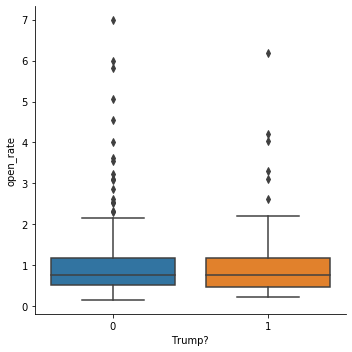

In [275]:
sns.catplot(x='Trump?',y='open_rate', kind='box', data=open_rate_agg2);

In [272]:
open_rate_agg2.corr()

,Trump?,open_rate
Trump?,1.00000,-0.01199
open_rate,-0.01199,1.00000


#### Finding:
*No correlation between "Trump" in the hed and open rate*

#### How about "impeachment" or "impeach" in the title?

In [278]:
df['Impeach?'] = df.url.isin(df[(df.title.str.contains('mpeach'))|(df.title.str.contains('mpeachment'))].url)

In [280]:
df['Impeach?'].value_counts()

False    734
True      40
Name: Impeach?, dtype: int64

Filtering to just the Politics category

In [281]:
open_rate_agg3 = round((df[df.cat == 'EN_US_POLITICS'].groupby(['dt', 'url', 'Impeach?']).agg({'opens':'sum', 'sent_count':'sum'}).opens / df.groupby('dt').agg({
    'opens':'sum', 'sent_count':'sum'}).sent_count) * 100.0, 2).to_frame().rename({0:'open_rate'}, axis=1)

In [286]:
open_rate_agg3.reset_index(inplace=True)

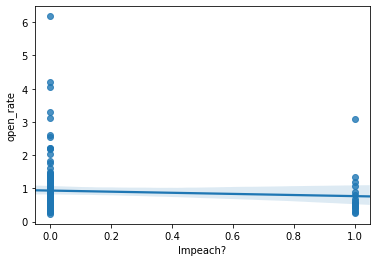

In [287]:
sns.regplot(x="Impeach?", y="open_rate", data=open_rate_agg3);

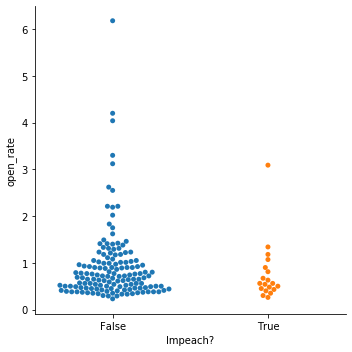

In [289]:
sns.catplot(x='Impeach?',y='open_rate', kind='swarm', data=open_rate_agg3);

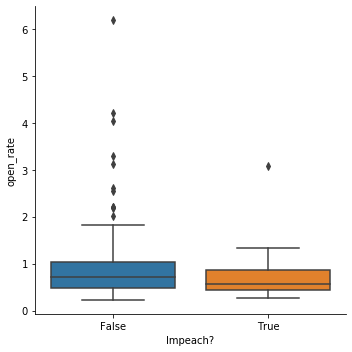

In [290]:
sns.catplot(x='Impeach?',y='open_rate', kind='box', data=open_rate_agg3);

In [288]:
open_rate_agg3.corr()

,Impeach?,open_rate
Impeach?,1.000000,-0.069247
open_rate,-0.069247,1.000000


#### Finding: 
*Very slight negative correlation*

### Findings

1. Open rate for BPs is declining, and its declining across different categories

2. National, Lifestyle, and Entertainment categories have the highest average open rates, and also the biggest spread (some high performers, some very low performers). Politics has average open rate with small spread of results.

3. Open rate is negatively correlated with # of BPs sent per day. Though this does not explain the declining open rate over time

4. Length of title has only a slight negative correlation for iOS users. 

5. "Trump" being in the title of the push has no relationship with open rate

### Follow up analyses

1. Is open rate declining across all cohorts (new/existing users, FB vs preload new users, Entertainment vs Politics readers, etc.)?

2. Is open rate declining across all types of pushes? Can this be explained by increasing number of pushes per day?

3. Is there an open rate decay that becomes obvious when you follow a particular cohort of users over time? (E.g. if you follow users who installed one week in July, do their open rates decline over time as they become desensitized to our pushes?)